In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import wandb
import multiprocessing
import matplotlib.pyplot as plt
import chardet
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
import dask.dataframe as dd
import pvlib
import plotly.graph_objects as go
import xgboost as xgb

# Setting wandb and others

In [3]:
os.environ["WANDB_NOTEBOOK_NAME"] = "ML.ipynb"

In [6]:
wandb.login()

wandb: Currently logged in as: akoagg (LukaszGawenda). Use `wandb login --relogin` to force relogin


True

Insert your login Id here 

In [7]:
!wandb login f860f5344a3596b6806fb4117cdab6bfaa45b26c

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Lukasz\.netrc


In [8]:
if torch.cuda.is_available():
    # Set the default device to the available GPU
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print(f"Using CUDA: {torch.cuda.get_device_name(device)}")
else:
    # If CUDA is not available, use the CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using CUDA: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
ncpus = multiprocessing.cpu_count()
print(f'Number of CPUs: {ncpus}')
n_job=ncpus-2 # decrease number of ncpus job to avoid memory error
print(f'Set number of jobs: {n_job}')

# Data Processing

Function to check missing value their percentage, type of data and nun-numeric columns

In [9]:
def check_dataframe_for_ml(dataframe):
    result = {}

    missing_values = dataframe.isnull().sum()
    result['missing_values'] = missing_values.to_dict()

    missing_percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    result['missing_percent'] = missing_percent.to_dict()

    data_types = dataframe.dtypes
    result['data_types'] = data_types.to_dict()

    non_numeric_columns = data_types[data_types != 'int64'][data_types != 'float64'].index
    result['non_numeric_columns'] = non_numeric_columns.tolist()

    return result

## Resampling and loading data

In [10]:
def process_dataframe(df):
    resampled_data = []

    # Get the unique station names
    stations = np.sort(df['name'].astype(str).unique())
    df['datetime'] = pd.to_datetime(df['datetime'])
    # get date and time columns for Rayman
    df["date"] = df['datetime'].dt.strftime('%d.%m.%Y')
    df["time"] = df['datetime'].dt.strftime('%H:%M')
    for station in stations:
        # Select the data for the current station
        station_df = df[df['name'] == station]

        # Set 'datetime' as the index
        station_df.set_index('datetime', inplace=True)
        # Resample the data to the hour values
        resampled_station_df = station_df.resample('h').agg({
            'precip': 'sum',  # Sum of 'precip' over each hour
            'temp': 'first',  # First 'temp' value in each hour
            'pressure': 'first',  # First 'pressure' value in each hour
            'humidity': 'first',  # First 'humidity' value in each hour
            'wind_speed': 'mean',  # Average 'wind_speed' over each hour
            'wind_gust': 'max',  # Maximum 'wind_gust' in each hour
            'lat': 'first',  # First 'lat' value in each hour
            'lon': 'first',  # First 'lon' value in each hour
            'name': 'first',  # First 'name' value in each hour
            'date' : 'first', # First 'date' value in each hour
            'time' : 'first' # First 'time' value in each hour
        })

        resampled_station_df.reset_index(inplace=True)

        resampled_data.append(resampled_station_df)

    resampled_df = pd.concat(resampled_data)

    # Here I delete repeated values of temperature in rows to decrease amount of repetitive data

    # Identify the rows where 'temp' value changes
    mask = resampled_df['temp'].shift() != resampled_df['temp']

    # Create a new column 'group' to identify the groups of rows where 'temp' value is the same
    resampled_df['group'] = mask.cumsum()

    # Count the number of rows in each group
    counts = resampled_df.groupby('group')['temp'].transform('count')

    # If temp is same for 4 consctutive hours, then keep the first row and remove the rest
    mask = counts > 4

    # Remove the rows where 'mask' value is False
    resampled_df = resampled_df[mask]

    # Remove the 'group' column to clean the df 
    resampled_df.drop('group', axis=1, inplace=True)

    # Remove rows with missing values
    resampled_df = resampled_df.dropna()

    resampled_df.reset_index(drop=True, inplace=True)
    return resampled_df

In [11]:
# loading all data
df_20 = pd.read_csv(f'Data/Vlinder_2020.csv')
df_21 = pd.read_csv(f'Data/Vlinder_2021.csv')
df_22 = pd.read_csv(f'Data/Vlinder_2022.csv')
df_23 = pd.read_csv(f'Data/Vlinder_2023.csv')

In [12]:
df_20_r = process_dataframe(df_20)
df_21_r = process_dataframe(df_21)
df_22_r = process_dataframe(df_22) 
df_23_r = process_dataframe(df_23)

Clean memory as we will not use it 

In [13]:
del df_20, df_21, df_22, df_23

Function for preparing data for Rayman

In [14]:
def generate_rayman_input(df, name):
    rayman_df = df[['date', 'time', 'lat', 'lon','temp', 'humidity', 'wind_speed']]
    rayman_df.to_csv(f'{name}.csv', index=False)

In [15]:
# generate_rayman_input(df_20_r, 'input_2020')
# generate_rayman_input(df_21_r, 'input_2021')
# generate_rayman_input(df_22_r, 'input_2022')
# generate_rayman_input(df_23_r, 'input_2023')

Check of values

In [16]:
# plt.figure(figsize=(16, 10))
# plt.plot(test['humidity'][500:700]/4, label='humidity', marker='o')
# plt.plot(test['temp'][500:700], label='temp', marker='o')
# plt.xlabel('Index')
# plt.ylabel('Precip')
# plt.title('Precip vs Precip sum')
# #plt.ylim(0, 5)
# plt.legend()
# plt.show()

In [17]:
# plt.figure(figsize=(16, 10))
# plt.plot(test_df['precip'][:1000], label='Precip')
# plt.plot(test_df['humidity'][:1000]/50, label='humidity')
# plt.plot(test_df['precip_sum'][:1000], label='Precip sum')
# plt.xlabel('Index')
# plt.ylabel('Precip')
# plt.title('Precip vs Precip sum')
# plt.ylim(0, 5)
# plt.legend()
# plt.show()

In [18]:
# plt.figure(figsize=(16, 10))
# plt.plot(test_df['pressure'], label='Pressure')
# plt.plot(test_df['pressure_at_sea_level'], label='Pressure at Sea Level')
# plt.xlabel('Index')
# plt.ylabel('Pressure')
# plt.title('Pressure vs Pressure at Sea Level')
# plt.legend()
# plt.show()

## Loading Rayman Results

In [19]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read(1000))  # Sample to check encoding
    return result['encoding']

In [20]:
def load_data(file_path):
    encoding = detect_encoding(file_path)
    ddf = dd.read_csv(file_path,
                      sep = '\t', # tab seperated
                      encoding=encoding,
                      assume_missing=False, # in case of missing data make it float as that what pandas expect to get NaNs
                      sample=1000000,
                      skiprows=3,
                      header=0)
    # Drop the specified columns as we dont need them in ML
    ddf = ddf.drop(columns=['height', 'weight', 'age', 'sex', 'cloth.', 'activ.'])
    
    # Drop columns that start with "Unnamed:" as they always get generated from Rayman Text File
    ddf = ddf.drop(columns=[col for col in ddf.columns if col.startswith('Unnamed:')])
    
    df = ddf.compute()
   
    # Drop the first row with units
    df = df.drop(df.index[0])

    columns_to_convert = ['Latit.', 'Long.', 'A', 'Ta', 'RH', 'v', 'PET']
    for col in columns_to_convert:
        df[col] = df[col].astype('float64')
    return df


In [21]:
df_20_ro= load_data('output_2020.txt')
df_21_ro = load_data('output_2021.txt')
df_22_ro = load_data('output_2022.txt')
df_23_ro = load_data('output_2023.txt')

d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (2,3,4,5,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (2,3,4,5,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (2,3,4,5,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (2,3,4,5,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Check shapes so we know rayman don't cut some values out

In [22]:
def check_shapes(rayman_input, rayman_output):
    return rayman_input.shape[0] == rayman_output.shape[0] 

In [23]:
print(check_shapes(df_20_r, df_20_ro))
print(check_shapes(df_21_r, df_21_ro))
print(check_shapes(df_22_r, df_22_ro))
print(check_shapes(df_23_r, df_23_ro))

True
True
True
True


## Create dataframe used for Machine Learning 

In [24]:
df_ml = pd.concat([df_20_r, df_21_r, df_22_r, df_23_r]).reset_index(drop=True)
df_ro = pd.concat([df_20_ro, df_21_ro, df_22_ro, df_23_ro]).reset_index(drop=True)
# Select the required columns from df_r
df_ml = df_ml[['datetime', 'time', 'precip', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_gust', 'lat', 'lon',]]
df_ml['PET'] = df_ro['PET']
print(df_ml.shape[0] == df_20_r.shape[0] + df_21_r.shape[0] + df_22_r.shape[0] + df_23_r.shape[0])

True


Clean memory of not used df

In [25]:
del df_20_r, df_21_r, df_22_r, df_23_r, df_20_ro, df_21_ro, df_22_ro, df_23_ro, df_ro

### Changing columns to numerical 

In [26]:
# Split 'time[h:mm]' into hours and minutes and convert them to integers
df_ml['hours'], df_ml['minutes'] = zip(*df_ml['time'].str.split(':').apply(lambda x: [int(i) for i in x]))

# Calculate decimal hour -> 21.5
df_ml['hour_decimal'] = df_ml['hours'] + df_ml['minutes'] / 60

# Extract day of the week and day of the year
df_ml['day_of_week'] = df_ml['datetime'].dt.dayofweek
df_ml['day_of_year'] = df_ml['datetime'].dt.dayofyear
df_ml['year'] = df_ml['datetime'].dt.year

# Convert to numerical values for ML
df_ml['hours'] = pd.to_numeric(df_ml['hours'])
df_ml['minutes'] = pd.to_numeric(df_ml['minutes'])
df_ml['day_of_week'] = pd.to_numeric(df_ml['day_of_week'])
df_ml['day_of_year'] = pd.to_numeric(df_ml['day_of_year'])
df_ml['year'] = pd.to_numeric(df_ml['year'])

df_ml[['datetime', 'hours', 'minutes', 'hour_decimal', 'day_of_week', 'day_of_year']].tail(10)

,datetime,hours,minutes,hour_decimal,day_of_week,day_of_year
2144526,2023-12-30 15:00:00,15,0,15.0,5,364
2144527,2023-12-30 16:00:00,16,0,16.0,5,364
2144528,2023-12-30 17:00:00,17,0,17.0,5,364
2144529,2023-12-30 18:00:00,18,0,18.0,5,364
2144530,2023-12-30 19:00:00,19,0,19.0,5,364
2144531,2023-12-30 20:00:00,20,0,20.0,5,364
2144532,2023-12-30 21:00:00,21,0,21.0,5,364
2144533,2023-12-30 22:00:00,22,0,22.0,5,364
2144534,2023-12-30 23:00:00,23,0,23.0,5,364
2144535,2023-12-31 00:00:00,0,0,0.0,6,365


Preserving the cyclical nature of your inputs. We want our machine learning algorithm to know that 1 day of the week is close to 7th day of the week.

In [27]:
# Convert 'day_of_week', 'day_of_year', and 'hour_decimal' to their sine and cosine transformations
df_ml['sin_day_of_week'] = np.sin(2 * np.pi * df_ml['day_of_week']/max(df_ml['day_of_week']))
df_ml['cos_day_of_week'] = np.cos(2 * np.pi * df_ml['day_of_week']/max(df_ml['day_of_week']))
df_ml['sin_day_of_year'] = np.sin(2 * np.pi * df_ml['day_of_year']/max(df_ml['day_of_year']))
df_ml['cos_day_of_year'] = np.cos(2 * np.pi * df_ml['day_of_year']/max(df_ml['day_of_year']))
df_ml['sin_hour_decimal'] = np.sin(2 * np.pi * df_ml['hour_decimal']/max(df_ml['hour_decimal']))
df_ml['cos_hour_decimal'] = np.cos(2 * np.pi * df_ml['hour_decimal']/max(df_ml['hour_decimal']))

In [28]:
# Print the original values
df_ml[['datetime', 'hours', 'minutes', 'hour_decimal', 'day_of_week', 'day_of_year']].tail(100)

,datetime,hours,minutes,hour_decimal,day_of_week,day_of_year
2144436,2023-12-22 00:00:00,0,0,0.0,4,356
2144437,2023-12-22 01:00:00,1,0,1.0,4,356
2144438,2023-12-22 02:00:00,2,0,2.0,4,356
2144439,2023-12-22 03:00:00,3,0,3.0,4,356
2144440,2023-12-22 04:00:00,4,0,4.0,4,356
...,...,...,...,...,...,...
2144531,2023-12-30 20:00:00,20,0,20.0,5,364
2144532,2023-12-30 21:00:00,21,0,21.0,5,364
2144533,2023-12-30 22:00:00,22,0,22.0,5,364
2144534,2023-12-30 23:00:00,23,0,23.0,5,364


In [29]:
# Print the transformed values
df_ml[['sin_day_of_week', 'cos_day_of_week', 'sin_day_of_year', 'cos_day_of_year', 'sin_hour_decimal', 'cos_hour_decimal']].tail()

,sin_day_of_week,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_hour_decimal,cos_hour_decimal
2144531,-8.660254e-01,0.5,-0.034328,0.999411,-0.744156,0.668006
2144532,-8.660254e-01,0.5,-0.034328,0.999411,-0.537167,0.843476
2144533,-8.660254e-01,0.5,-0.034328,0.999411,-0.290624,0.956837
2144534,-8.660254e-01,0.5,-0.034328,0.999411,-0.022681,0.999743
2144535,-2.449294e-16,1.0,-0.017166,0.999853,0.000000,1.000000


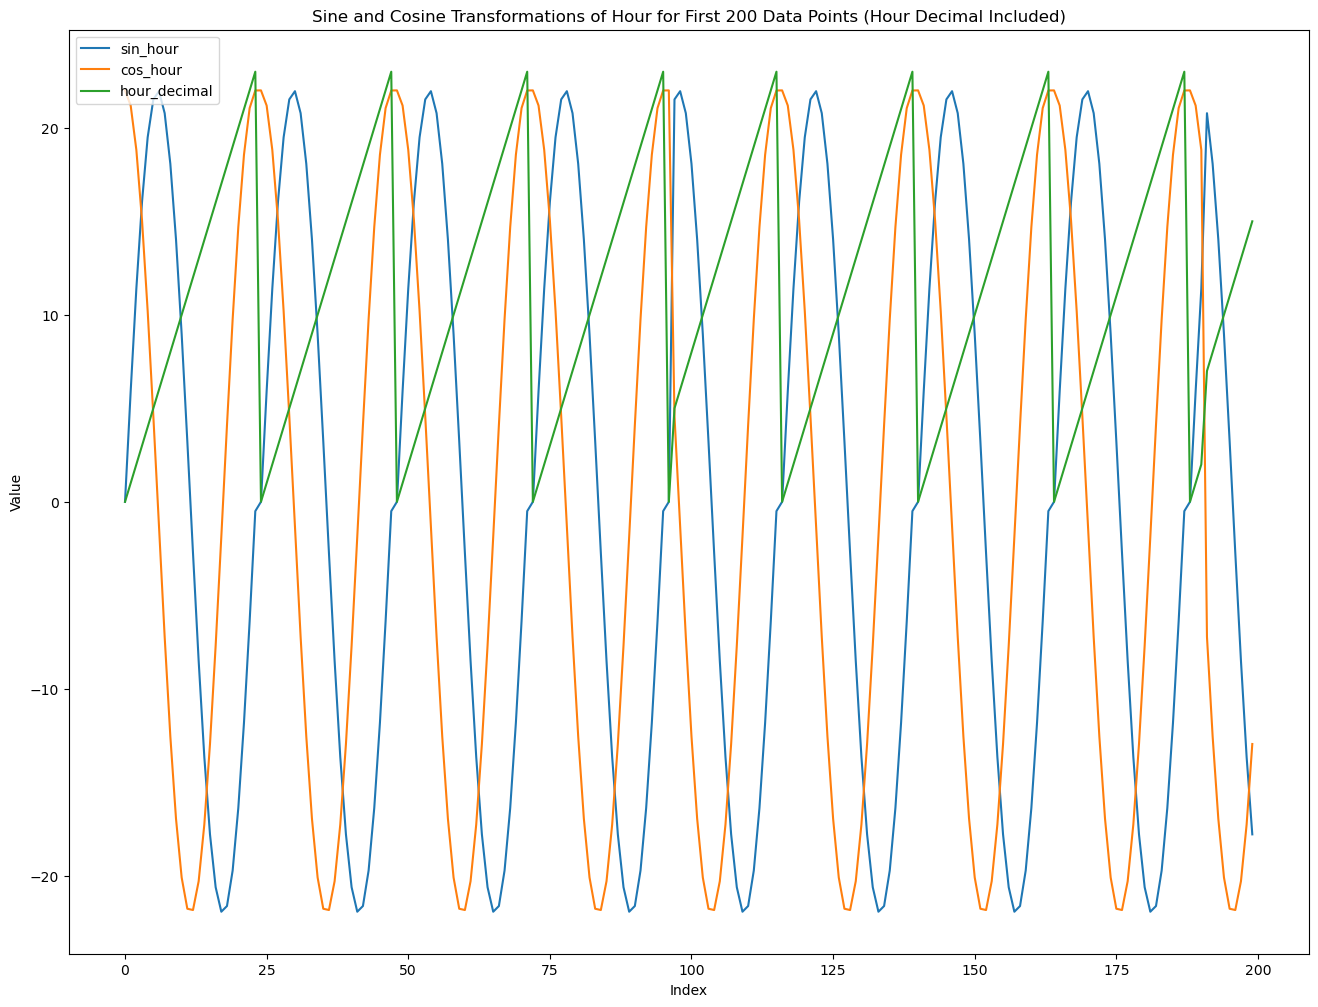

In [52]:
samples = 200 # sample size for clarity of the plot
scale = df_ml['hour_decimal'].iloc[:samples].max() - df_ml['sin_hour_decimal'].iloc[:samples].max()
plt.figure(figsize=(16, 12)) 
plt.plot(df_ml['sin_hour_decimal'].iloc[:samples]*scale, label='sin_hour')
plt.plot(df_ml['cos_hour_decimal'].iloc[:samples]*scale, label='cos_hour')
plt.plot(df_ml['hour_decimal'].iloc[:samples], label='hour_decimal')
plt.title(f'Sine and Cosine Transformations of Hour for First {samples} Data Points (Hour Decimal Included)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

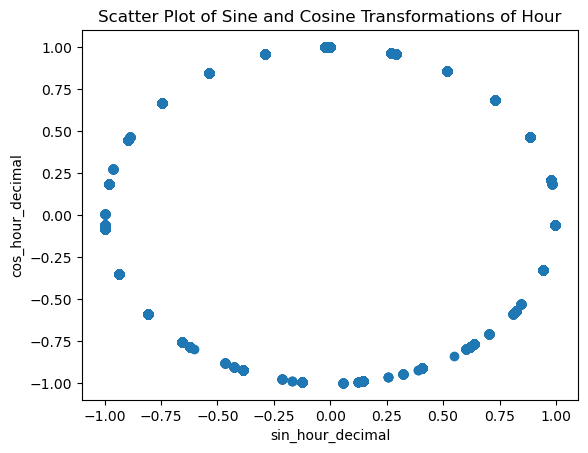

<Figure size 1600x1600 with 0 Axes>

In [53]:
plt.scatter(df_ml['sin_hour_decimal'], df_ml['cos_hour_decimal'])
plt.title('Scatter Plot of Sine and Cosine Transformations of Hour')
plt.xlabel('sin_hour_decimal')
plt.ylabel('cos_hour_decimal')
plt.figure(figsize=(16, 16))
plt.show()

### Cutting values that have one unique value across dataset

In [30]:
df_ml.shape

(2144536, 23)

In [55]:
for column in df_ml.columns:
    # Check the number of unique entries in each column as they don't provide any useful information for ML
    print(f"Column {column} has {df_ml[column].nunique()} unique values.")
    if df_ml[column].nunique() <= 1:
        df_ml.drop(column, axis=1, inplace=True)

# Check the dimensions of df_corr to verify the number of rows and columns
print(f"We had {df_ml.shape[1]} values, now we have {df_ml.shape[1]}")  
df_ml['minutes']

Column datetime has 33856 unique values.
Column time has 48 unique values.
Column precip has 308 unique values.
Column temp has 525 unique values.
Column pressure has 8510 unique values.
Column humidity has 99 unique values.
Column wind_speed has 8680 unique values.
Column wind_gust has 113 unique values.
Column lat has 79 unique values.
Column lon has 79 unique values.
Column PET has 744 unique values.
Column hours has 24 unique values.
Column minutes has 9 unique values.
Column hour_decimal has 48 unique values.
Column day_of_week has 7 unique values.
Column day_of_year has 366 unique values.
Column sin_day_of_week has 7 unique values.
Column cos_day_of_week has 5 unique values.
Column sin_day_of_year has 324 unique values.
Column cos_day_of_year has 337 unique values.
Column sin_hour_decimal has 48 unique values.
Column cos_hour_decimal has 47 unique values.
We had 22 values, now we have 22


0          0
1          0
2          0
3          0
4          0
          ..
2144531    0
2144532    0
2144533    0
2144534    0
2144535    0
Name: minutes, Length: 2144536, dtype: int64

## Check final df

In [32]:
check_dataframe_for_ml(df_ml)

{'missing_values': {'datetime': 0,
  'time': 0,
  'precip': 0,
  'temp': 0,
  'pressure': 0,
  'humidity': 0,
  'wind_speed': 0,
  'wind_gust': 0,
  'lat': 0,
  'lon': 0,
  'PET': 0,
  'hours': 0,
  'minutes': 0,
  'hour_decimal': 0,
  'day_of_week': 0,
  'day_of_year': 0,
  'year': 0,
  'sin_day_of_week': 0,
  'cos_day_of_week': 0,
  'sin_day_of_year': 0,
  'cos_day_of_year': 0,
  'sin_hour_decimal': 0,
  'cos_hour_decimal': 0},
 'missing_percent': {'datetime': 0.0,
  'minutes': 0.0,
  'sin_hour_decimal': 0.0,
  'cos_day_of_year': 0.0,
  'sin_day_of_year': 0.0,
  'cos_day_of_week': 0.0,
  'sin_day_of_week': 0.0,
  'year': 0.0,
  'day_of_year': 0.0,
  'day_of_week': 0.0,
  'hour_decimal': 0.0,
  'hours': 0.0,
  'time': 0.0,
  'PET': 0.0,
  'lon': 0.0,
  'lat': 0.0,
  'wind_gust': 0.0,
  'wind_speed': 0.0,
  'humidity': 0.0,
  'pressure': 0.0,
  'temp': 0.0,
  'precip': 0.0,
  'cos_hour_decimal': 0.0},
 'data_types': {'datetime': dtype('<M8[ns]'),
  'time': dtype('O'),
  'precip': dtype

## Adding Solar position to the data

- https://github.com/pvlib/pvlib-python
- https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html

In [58]:
df_ml.columns

Index(['datetime', 'time', 'precip', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_gust', 'lat', 'lon', 'PET', 'hours', 'minutes',
       'hour_decimal', 'day_of_week', 'day_of_year', 'sin_day_of_week',
       'cos_day_of_week', 'sin_day_of_year', 'cos_day_of_year',
       'sin_hour_decimal', 'cos_hour_decimal'],
      dtype='object')

In [33]:
# Set 'datetime' column as the index need for solar calculations
df_corr = df_ml.copy()
df_corr.set_index(df_ml['datetime'], inplace=True)
df_corr.head()

,datetime,time,precip,temp,pressure,humidity,wind_speed,wind_gust,lat,lon,...,hour_decimal,day_of_week,day_of_year,year,sin_day_of_week,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_hour_decimal,cos_hour_decimal
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,00:00,0.0,3.5,103131.0,97.0,8.475000,17.7,50.980438,3.815763,...,0.0,2,1,2020,0.866025,-0.5,0.017166,0.999853,0.000000,1.000000
2020-01-01 01:00:00,2020-01-01 01:00:00,01:00,0.0,3.8,103089.0,97.0,6.391667,14.5,50.980438,3.815763,...,1.0,2,1,2020,0.866025,-0.5,0.017166,0.999853,0.268847,0.963183
2020-01-01 02:00:00,2020-01-01 02:00:00,02:00,0.0,3.9,103035.0,96.0,7.458333,16.1,50.980438,3.815763,...,2.0,2,1,2020,0.866025,-0.5,0.017166,0.999853,0.517898,0.855443
2020-01-01 03:00:00,2020-01-01 03:00:00,03:00,0.0,3.7,102981.0,95.0,6.266667,17.7,50.980438,3.815763,...,3.0,2,1,2020,0.866025,-0.5,0.017166,0.999853,0.728813,0.684712
2020-01-01 04:00:00,2020-01-01 04:00:00,04:00,0.0,3.4,102924.0,95.0,3.550000,8.1,50.980438,3.815763,...,4.0,2,1,2020,0.866025,-0.5,0.017166,0.999853,0.886063,0.463564


In [60]:
df_corr.columns

Index(['datetime', 'time', 'precip', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_gust', 'lat', 'lon', 'PET', 'hours', 'minutes',
       'hour_decimal', 'day_of_week', 'day_of_year', 'sin_day_of_week',
       'cos_day_of_week', 'sin_day_of_year', 'cos_day_of_year',
       'sin_hour_decimal', 'cos_hour_decimal'],
      dtype='object')

In [34]:


# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(df_corr['datetime'], latitude=df_corr['lat'], longitude=df_corr['lon'], altitude=0, temperature=df_corr["temp"], pressure=df_corr["pressure"])

In [35]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
datetime,,,,,,
2020-01-01 00:00:00,151.979662,151.979662,-61.979662,-61.979662,5.970603,-3.081724
2020-01-01 01:00:00,148.770560,148.770560,-58.770560,-58.770560,33.336701,-3.101587
2020-01-01 02:00:00,142.176396,142.176396,-52.176396,-52.176396,54.880554,-3.121441
2020-01-01 03:00:00,133.759222,133.759222,-43.759222,-43.759222,71.297852,-3.141287
2020-01-01 04:00:00,124.538953,124.538953,-34.538953,-34.538953,84.578404,-3.161123
...,...,...,...,...,...,...
2023-12-30 20:00:00,128.878434,128.878434,-38.878434,-38.878434,281.250049,-2.518515
2023-12-30 21:00:00,137.795747,137.795747,-47.795747,-47.795747,295.770196,-2.538502
2023-12-30 22:00:00,145.509918,145.509918,-55.509918,-55.509918,314.309953,-2.558482


In [36]:
df_corr['datetime'] = df_corr['datetime'].apply(lambda x: x.timestamp()) # convert to timestamp

In [37]:
df_corr

,datetime,time,precip,temp,pressure,humidity,wind_speed,wind_gust,lat,lon,...,hour_decimal,day_of_week,day_of_year,year,sin_day_of_week,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_hour_decimal,cos_hour_decimal
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.577837e+09,00:00,0.0,3.5,103131.0,97.0,8.475000,17.7,50.980438,3.815763,...,0.0,2,1,2020,8.660254e-01,-0.5,0.017166,0.999853,0.000000,1.000000
2020-01-01 01:00:00,1.577840e+09,01:00,0.0,3.8,103089.0,97.0,6.391667,14.5,50.980438,3.815763,...,1.0,2,1,2020,8.660254e-01,-0.5,0.017166,0.999853,0.268847,0.963183
2020-01-01 02:00:00,1.577844e+09,02:00,0.0,3.9,103035.0,96.0,7.458333,16.1,50.980438,3.815763,...,2.0,2,1,2020,8.660254e-01,-0.5,0.017166,0.999853,0.517898,0.855443
2020-01-01 03:00:00,1.577848e+09,03:00,0.0,3.7,102981.0,95.0,6.266667,17.7,50.980438,3.815763,...,3.0,2,1,2020,8.660254e-01,-0.5,0.017166,0.999853,0.728813,0.684712
2020-01-01 04:00:00,1.577851e+09,04:00,0.0,3.4,102924.0,95.0,3.550000,8.1,50.980438,3.815763,...,4.0,2,1,2020,8.660254e-01,-0.5,0.017166,0.999853,0.886063,0.463564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,1.703966e+09,20:00,0.0,9.9,100941.0,89.0,4.333333,14.5,51.093160,4.494440,...,20.0,5,364,2023,-8.660254e-01,0.5,-0.034328,0.999411,-0.744156,0.668006
2023-12-30 21:00:00,1.703970e+09,21:00,0.0,9.9,100850.0,90.0,5.258333,16.1,51.093160,4.494440,...,21.0,5,364,2023,-8.660254e-01,0.5,-0.034328,0.999411,-0.537167,0.843476
2023-12-30 22:00:00,1.703974e+09,22:00,0.0,10.0,100717.0,85.0,4.333333,14.5,51.093160,4.494440,...,22.0,5,364,2023,-8.660254e-01,0.5,-0.034328,0.999411,-0.290624,0.956837


In [38]:
df_ml = pd.concat([df_ml.reset_index(drop=True), solar_position.reset_index(drop=True)], axis=1)
# Converting 'time' column to datetime format
df_ml['time'] = pd.to_datetime(df_ml['time'])

# Converting 'time' column to number of seconds past midnight
df_ml['time'] = df_ml['time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

C:\Users\Lukasz\AppData\Local\Temp\ipykernel_26084\1238454546.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ml['time'] = pd.to_datetime(df_ml['time'])


## ML 

In [40]:
selected_columns = ['year', 'hours', 'minutes', 'hour_decimal', 'day_of_week',
       'day_of_year', 'sin_day_of_week', 'cos_day_of_week', 'sin_day_of_year',
       'cos_day_of_year', 'sin_hour_decimal', 'cos_hour_decimal',
       'apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'precip', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_gust', 'lat', 'lon', 'PET',]

df_corr = df_ml[selected_columns].copy()

In [41]:
df_corr.to_csv('df_corr2.csv')

# Future Selection

## Correlation Matrix

In [ ]:
corr_matrix = df_corr.corr()

pet_correlations = corr_matrix['PET'].sort_values(ascending=False)



# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Reds',  
    colorbar=dict(title='Correlation Coefficient'),
))

fig.update_layout(
    title_text='Correlation Matrix Heatmap',
    title_x=0.5,
    width=1000,
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig.show()
print(pet_correlations)
# Save the figure to HTML
fig.write_html("Heatmap.html")

PET                   1.000000
temp                  0.933064
elevation             0.599528
apparent_elevation    0.599279
day_of_year           0.173516
azimuth               0.162953
hour_decimal          0.149635
hours                 0.149633
equation_of_time      0.055889
lon                   0.026740
sin_day_of_week       0.007248
pressure              0.003804
minutes               0.001836
lat                   0.000314
day_of_week          -0.000633
precip               -0.003167
cos_day_of_week      -0.005263
wind_gust            -0.121751
wind_speed           -0.156356
sin_hour_decimal     -0.230893
sin_day_of_year      -0.252341
cos_hour_decimal     -0.337800
humidity             -0.560563
apparent_zenith      -0.599279
zenith               -0.599528
cos_day_of_year      -0.682046
Name: PET, dtype: float64


## Feature importance 

### Random Forest

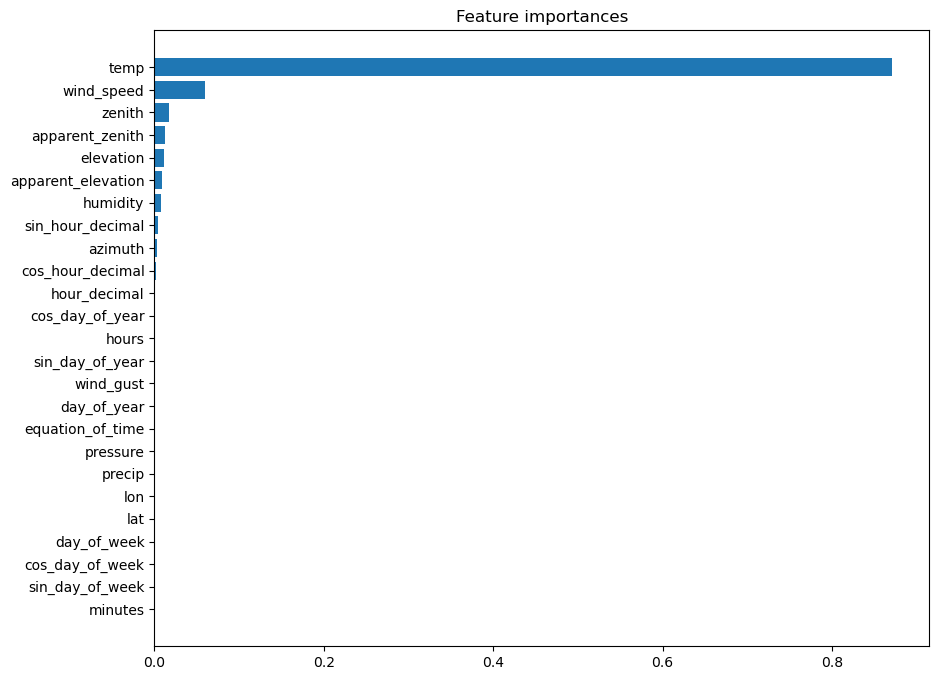

               feature    importance
18                temp  8.713206e-01
21          wind_speed  6.000032e-02
12              zenith  1.674228e-02
11     apparent_zenith  1.263973e-02
14           elevation  1.120060e-02
13  apparent_elevation  9.040462e-03
20            humidity  7.639789e-03
9     sin_hour_decimal  4.836839e-03
15             azimuth  2.867161e-03
10    cos_hour_decimal  1.679824e-03
2         hour_decimal  7.504957e-04
8      cos_day_of_year  5.125221e-04
0                hours  3.506261e-04
7      sin_day_of_year  1.058928e-04
22           wind_gust  8.847354e-05
4          day_of_year  7.959807e-05
16    equation_of_time  7.224611e-05
19            pressure  2.412442e-05
17              precip  2.024998e-05
24                 lon  9.032869e-06
23                 lat  8.398504e-06
3          day_of_week  5.133107e-06
6      cos_day_of_week  3.161085e-06
5      sin_day_of_week  2.422145e-06
1              minutes  4.195037e-08


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_fi = df_corr.drop('PET', axis=1)
y_fi = df_corr['PET']

X_train, X_test, y_train, y_test = train_test_split(X_fi, y_fi, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=n_job, random_state=42)
rf.fit(X_train, y_train)

# Saving future importance
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X_fi.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.barh(feature_importances['feature'], feature_importances['importance'], align="center")
plt.gca().invert_yaxis()
plt.show()
print(feature_importances)

### XGB Boost

               feature  importance
18                temp    0.240207
20            humidity    0.115713
14           elevation    0.082676
12              zenith    0.076254
8      cos_day_of_year    0.065532
10    cos_hour_decimal    0.059996
4          day_of_year    0.051512
0                hours    0.048777
16    equation_of_time    0.045234
22           wind_gust    0.044089
7      sin_day_of_year    0.039393
21          wind_speed    0.024059
2         hour_decimal    0.023051
15             azimuth    0.019788
9     sin_hour_decimal    0.011058
13  apparent_elevation    0.010137
3          day_of_week    0.008164
23                 lat    0.007092
6      cos_day_of_week    0.006024
11     apparent_zenith    0.005650
5      sin_day_of_week    0.004926
19            pressure    0.004377
24                 lon    0.003588
17              precip    0.002527
1              minutes    0.000174


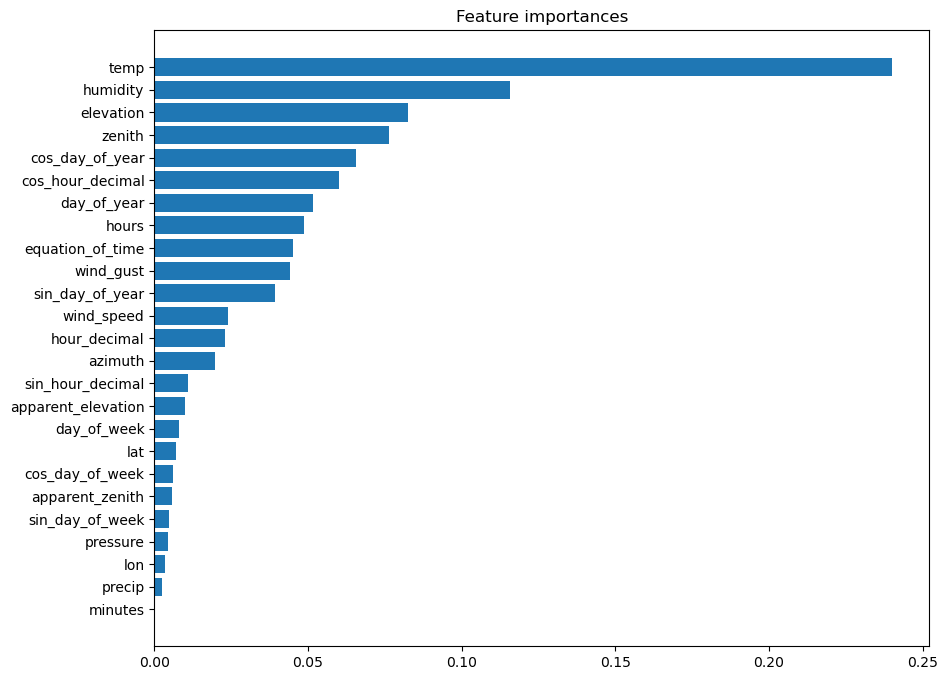

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                max_depth = 15, n_estimators = 100,  n_jobs=n_job)
xg_reg.fit(X_train,y_train)

# Saving feature importances values
importances = xg_reg.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.barh(feature_importances['feature'], feature_importances['importance'], align="center")
plt.gca().invert_yaxis()
plt.show()

## Recursive Feature Elimination (RFE)

Recursive Feature Elimination (RFE)
Mechanism: Works by recursively removing features, building a model using the remaining features, and evaluating model performance. In each iteration, the least important feature(s) (e.g., based on model coefficients or feature importance scores) is removed, and the process is repeated until the desired number of features is reached.

In [ ]:
X = df_corr.drop('PET', axis=1)
y = df_corr['PET']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42,  max_depth=15,)

# Initialize RFE with 6 features to select and deleting one feature at a time
rfe = RFE(estimator=model, n_features_to_select=6, step=1)

rfe = rfe.fit(X, y)

# Save the features ranking
ranking = rfe.ranking_

# Get a mask of the selected features
selected_features = rfe.support_

print('Features ranking:', ranking)

print('Selected features:', selected_features)

Features ranking: [ 8 20  6 17 12 19 18  9  7  1  5  1  1  2  1  4 10 16  1 13  3  1 11 15
 14]
Selected features: [False False False False False False False False False  True False  True
  True False  True False False False  True False False  True False False
 False] 1078 min 

In [ ]:
# Get the names of the selected features for printing
selected_feature_names = X.columns[selected_features]

print('Selected feature names:', selected_feature_names)

Selected feature names: Index(['sin_hour_decimal', 'apparent_zenith', 'zenith', 'elevation', 'temp',
       'wind_speed'],
      dtype='object')

In [ ]:
# Create a DataFrame with feature names and their rankings sort it and print
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': ranking})

feature_ranking = feature_ranking.sort_values('Ranking')

print(feature_ranking)

               Feature  Ranking
12              zenith        1
21          wind_speed        1
18                temp        1
14           elevation        1
9     sin_hour_decimal        1
11     apparent_zenith        1
13  apparent_elevation        2
20            humidity        3
15             azimuth        4
10    cos_hour_decimal        5
2         hour_decimal        6
8      cos_day_of_year        7
0                hours        8
7      sin_day_of_year        9
16    equation_of_time       10
22           wind_gust       11
4          day_of_year       12
19            pressure       13
24                 lon       14
23                 lat       15
17              precip       16
3          day_of_week       17
6      cos_day_of_week       18
5      sin_day_of_week       19
1              minutes       20